In [1]:
# ═══════════════════════════════════════════════════════════════════
#  GridSearch.ipynb — Unified Parameter Search
#  Uses IDENTICAL data pipeline & S_actual as Phase1a_Consolidated
# ═══════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from tqdm import tqdm

np.random.seed(42)
random.seed(42)

# ─── Canonical Configuration (MUST match Phase1a) ───────────
DATA_PATH      = 'd:/A/Warton/Data/whl_2025.csv'
ELO_BASE       = 1500.0
ELO_SCALE      = 400
MOV_LOG_BASE   = 1          # ln(|GD| + 1)
MOV_CAP        = 1.5

# Points System
PTS_REG_WIN  = 3
PTS_OT_WIN   = 2
PTS_OT_LOSS  = 1
PTS_REG_LOSS = 0

# ─── Step 1: Data Pipeline (SAME as Phase1a) ───────────────
def load_and_clean(filepath):
    """Load raw shift-level CSV, remove duplicates, KEEP empty-net rows."""
    df_raw = pd.read_csv(filepath)
    n_original = len(df_raw)
    if 'record_id' in df_raw.columns:
        dup_mask = df_raw.duplicated(subset=['record_id'])
    else:
        dup_mask = df_raw.duplicated()
    n_dups = int(dup_mask.sum())
    df_raw = df_raw.loc[~dup_mask].copy()
    
    # Tag empty-net rows but DO NOT remove (Phase1a decision)
    en_cols = ['home_goalie','away_goalie','home_off_line','away_off_line',
               'home_def_pairing','away_def_pairing']
    en_mask = pd.Series(False, index=df_raw.index)
    for col in en_cols:
        if col in df_raw.columns:
            en_mask |= df_raw[col].astype(str).str.contains('empty_net', case=False, na=False)
    df_raw['is_empty_net'] = en_mask.astype(int)
    
    print(f"✅ Loaded {n_original:,} records → {n_dups} dups removed → {len(df_raw):,} clean")
    print(f"   Empty-net rows KEPT: {int(en_mask.sum())} ({en_mask.mean()*100:.1f}%)")
    return df_raw

def aggregate_to_games(df_raw):
    """Collapse to game-level (SAME agg_rules as Phase1a)."""
    agg_rules = {
        'home_goals': 'sum', 'away_goals': 'sum',
        'home_xg': 'sum', 'away_xg': 'sum',
        'home_shots': 'sum', 'away_shots': 'sum',
        'went_ot': 'max',
        'home_team': 'first', 'away_team': 'first',
        'home_assists': 'sum', 'away_assists': 'sum',
        'home_penalties_committed': 'sum', 'away_penalties_committed': 'sum',
        'home_penalty_minutes': 'sum', 'away_penalty_minutes': 'sum',
    }
    df_games = df_raw.groupby('game_id').agg(agg_rules).reset_index()
    
    home_win = df_games['home_goals'] > df_games['away_goals']
    away_win = df_games['away_goals'] > df_games['home_goals']
    is_ot    = df_games['went_ot'] == 1
    
    df_games['home_points'] = PTS_REG_LOSS
    df_games.loc[home_win & ~is_ot, 'home_points'] = PTS_REG_WIN
    df_games.loc[home_win &  is_ot, 'home_points'] = PTS_OT_WIN
    df_games.loc[away_win &  is_ot, 'home_points'] = PTS_OT_LOSS
    
    df_games['away_points'] = PTS_REG_LOSS
    df_games.loc[away_win & ~is_ot, 'away_points'] = PTS_REG_WIN
    df_games.loc[away_win &  is_ot, 'away_points'] = PTS_OT_WIN
    df_games.loc[home_win &  is_ot, 'away_points'] = PTS_OT_LOSS
    
    df_games['goal_diff'] = df_games['home_goals'] - df_games['away_goals']
    df_games['xg_diff']   = df_games['home_xg'] - df_games['away_xg']
    
    n_draws = (df_games['home_goals'] == df_games['away_goals']).sum()
    print(f"✅ Aggregated into {len(df_games)} games (draws: {n_draws})")
    return df_games

def prepare_games_for_elo(df_games):
    """Convert game-level DF to list of dicts with xg_share & mov (Phase1a logic)."""
    games = []
    for _, row in df_games.iterrows():
        total_xg = row['home_xg'] + row['away_xg']
        xg_share_h = row['home_xg'] / total_xg if total_xg > 0 else 0.5
        xg_share_a = row['away_xg'] / total_xg if total_xg > 0 else 0.5
        raw_mov = np.log(abs(row['goal_diff']) + MOV_LOG_BASE)
        mov = min(raw_mov, MOV_CAP)
        games.append({
            'game_id':       row['game_id'],
            'home':          row['home_team'],
            'away':          row['away_team'],
            'home_pts':      row['home_points'],
            'xg_share_home': xg_share_h,
            'xg_share_away': xg_share_a,
            'mov_mult':      mov,
        })
    return games

# Run pipeline
df_raw   = load_and_clean(DATA_PATH)
df_games = aggregate_to_games(df_raw)
games_list = prepare_games_for_elo(df_games)

# Sort chronologically
def game_id_sort_key(g):
    m = re.search(r'(\d+)', g['game_id'])
    return int(m.group(1)) if m else 0

games_chrono = sorted(games_list, key=game_id_sort_key)
all_teams = list(set([g['home'] for g in games_chrono] + [g['away'] for g in games_chrono]))

print(f"\n✅ {len(games_chrono)} games ready, {len(all_teams)} teams")
print(f"   First: {games_chrono[0]['game_id']}, Last: {games_chrono[-1]['game_id']}")

✅ Loaded 25,827 records → 0 dups removed → 25,827 clean
   Empty-net rows KEPT: 2229 (8.6%)
✅ Aggregated into 1312 games (draws: 0)

✅ 1312 games ready, 32 teams
   First: game_1, Last: game_1312


In [2]:
# ═══════════════════════════════════════════════════════════════════
#  Ridge Regression: Extract HFA reference & team strength baseline
# ═══════════════════════════════════════════════════════════════════

# Build indicator matrix (SAME games data as above)
teams_sorted = sorted(all_teams)
X = pd.DataFrame(0, index=range(len(df_games)), columns=teams_sorted)

for idx, row in df_games.reset_index(drop=True).iterrows():
    X.loc[idx, row['home_team']] = 1
    X.loc[idx, row['away_team']] = -1

y = df_games['home_goals'].values - df_games['away_goals'].values

print(f"Ridge regression matrix: X={X.shape}, y={y.shape}")

# Grid search for best alpha
param_grid = {'alpha': [0.1, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]}
ridge = Ridge(fit_intercept=True)
grid_search = GridSearchCV(ridge, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
hfa_goals  = best_model.intercept_

print(f"\n--- Ridge Results ---")
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"HFA (goals/game): {hfa_goals:.4f}")
print(f"HFA → Elo reference (×35): {hfa_goals * 35:.1f}")

# Team ratings for reference (not used in Elo, just comparison)
team_ratings = pd.DataFrame({
    'Team': teams_sorted,
    'Ridge_Rating': best_model.coef_
}).sort_values('Ridge_Rating', ascending=False).reset_index(drop=True)
team_ratings['Rank'] = team_ratings.index + 1
print("\nTop 10 Teams (Ridge):")
display(team_ratings.head(10))

Ridge regression matrix: X=(1312, 32), y=(1312,)

--- Ridge Results ---
Best alpha: 50.0
HFA (goals/game): 0.4253
HFA → Elo reference (×35): 14.9

Top 10 Teams (Ridge):


,Team,Ridge_Rating,Rank
0,brazil,0.634789,1
1,peru,0.580708,2
2,netherlands,0.511197,3
3,pakistan,0.372310,4
4,china,0.342080,5
5,thailand,0.335580,6
6,panama,0.303907,7
7,uk,0.249826,8
8,iceland,0.226275,9
9,india,0.200702,10


In [3]:
# ═══════════════════════════════════════════════════════════════════
#  Time-Series Expanding-Window CV Function
#  Uses IDENTICAL S_actual as Phase1a: W_RESULT*(pts/3) + W_XG*xg_share
# ═══════════════════════════════════════════════════════════════════

def run_elo_season(games, teams, k, hfa, w_result, w_xg, mov_cap=MOV_CAP):
    """Run one Elo pass, return final ratings."""
    ratings = {t: ELO_BASE for t in teams}
    for g in games:
        r_h = ratings[g['home']]
        r_a = ratings[g['away']]
        
        exp_h = 1.0 / (1.0 + 10.0 ** ((r_a - (r_h + hfa)) / ELO_SCALE))
        
        pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
        hp, ap = g['home_pts'], pts_map.get(g['home_pts'], 0)
        
        # Phase1a canonical S_actual
        s_h = w_result * (hp / 3.0) + w_xg * g['xg_share_home']
        s_a = w_result * (ap / 3.0) + w_xg * g['xg_share_away']
        total = s_h + s_a
        if total == 0:
            s_h, s_a = 0.5, 0.5
        else:
            s_h /= total
            s_a /= total
        
        mov = min(g['mov_mult'], mov_cap)
        ratings[g['home']] = r_h + k * mov * (s_h - exp_h)
        ratings[g['away']] = r_a + k * mov * (s_a - (1.0 - exp_h))
    return ratings


def evaluate_ts_cv(games_chrono, teams, k, hfa, w_result, w_xg,
                   n_folds=3, n_mc=10):
    """
    Time-series expanding-window CV (NO information leakage).
    Fold 1: train 40%, test next 20%
    Fold 2: train 60%, test next 20%
    Fold 3: train 80%, test last 20%
    """
    n = len(games_chrono)
    fold_losses = []
    
    for fold in range(n_folds):
        train_end = int(n * (0.4 + 0.2 * fold))
        test_end  = int(n * (0.6 + 0.2 * fold)) if fold < n_folds - 1 else n
        
        train_games = games_chrono[:train_end]
        test_games  = games_chrono[train_end:test_end]
        if len(test_games) == 0:
            continue
        
        mc_losses = []
        for _ in range(n_mc):
            shuffled = train_games.copy()
            random.shuffle(shuffled)
            ratings = run_elo_season(shuffled, teams, k, hfa, w_result, w_xg)
            
            preds, actuals = [], []
            for g in test_games:
                r_h = ratings.get(g['home'], ELO_BASE)
                r_a = ratings.get(g['away'], ELO_BASE)
                
                p = 1.0 / (1.0 + 10.0 ** ((r_a - (r_h + hfa)) / ELO_SCALE))
                preds.append(np.clip(p, 1e-6, 1 - 1e-6))
                actuals.append(1 if g['home_pts'] >= 2 else 0)
                
                # Online update on test game
                pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
                ap = pts_map.get(g['home_pts'], 0)
                s_h = w_result * (g['home_pts']/3.0) + w_xg * g['xg_share_home']
                s_a = w_result * (ap/3.0) + w_xg * g['xg_share_away']
                tot = s_h + s_a
                if tot == 0: s_h, s_a = 0.5, 0.5
                else: s_h /= tot; s_a /= tot
                exp_h = 1.0 / (1.0 + 10.0 ** ((r_a - (r_h + hfa)) / ELO_SCALE))
                mov = min(g['mov_mult'], MOV_CAP)
                ratings[g['home']] = r_h + k * mov * (s_h - exp_h)
                ratings[g['away']] = r_a + k * mov * (s_a - (1.0 - exp_h))
            
            mc_losses.append(log_loss(actuals, preds))
        fold_losses.append(np.mean(mc_losses))
    
    return np.mean(fold_losses)

print("✅ Time-series CV function defined (Phase1a-consistent S_actual).")

✅ Time-series CV function defined (Phase1a-consistent S_actual).


  2D Grid Search: 7 K × 8 HFA = 56 configs
  Weights: W_result=0.4, W_xG=0.6
  CV: 3-fold expanding window × 10 MC runs each

   K |   HFA |   CV LogLoss
------------------------------
   8 |     0 | 0.68622 ← BEST
   8 |    10 | 0.68286 ← BEST
   8 |    20 | 0.68012 ← BEST
   8 |    30 | 0.67831 ← BEST
   8 |    40 | 0.67727 ← BEST
   8 |    50 | 0.67703 ← BEST
   8 |    60 | 0.67769
   8 |    70 | 0.67942
  12 |     0 | 0.68541
  12 |    10 | 0.68185
  12 |    20 | 0.67918
  12 |    30 | 0.67719
  12 |    40 | 0.67637 ← BEST
  12 |    50 | 0.67612 ← BEST
  12 |    60 | 0.67677
  12 |    70 | 0.67804
  16 |     0 | 0.68512
  16 |    10 | 0.68184
  16 |    20 | 0.67897
  16 |    30 | 0.67671
  16 |    40 | 0.67566 ← BEST
  16 |    50 | 0.67540 ← BEST
  16 |    60 | 0.67587
  16 |    70 | 0.67781
  20 |     0 | 0.68510
  20 |    10 | 0.68156
  20 |    20 | 0.67917
  20 |    30 | 0.67677
  20 |    40 | 0.67592
  20 |    50 | 0.67586
  20 |    60 | 0.67585
  20 |    70 | 0.67715
  24 |   

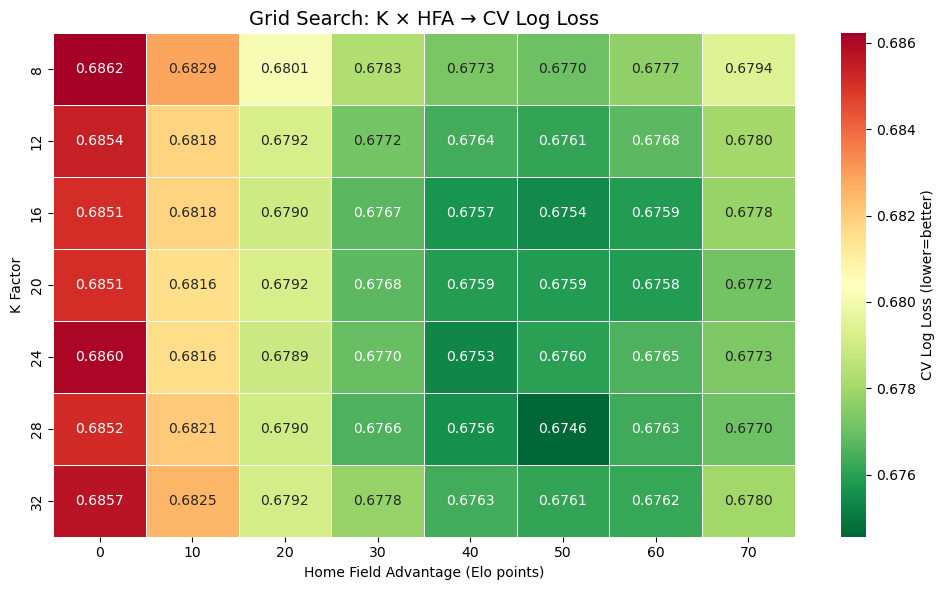

In [4]:
# ═══════════════════════════════════════════════════════════════════
#  2D Grid Search: K × HFA (with fixed Phase1a weights)
# ═══════════════════════════════════════════════════════════════════

W_RESULT_FIXED = 0.4   # Phase1a canonical weight
W_XG_FIXED     = 0.6   # Phase1a canonical weight

k_grid   = [8, 12, 16, 20, 24, 28, 32]
hfa_grid = [0, 10, 20, 30, 40, 50, 60, 70]

print(f"{'='*60}")
print(f"  2D Grid Search: {len(k_grid)} K × {len(hfa_grid)} HFA = {len(k_grid)*len(hfa_grid)} configs")
print(f"  Weights: W_result={W_RESULT_FIXED}, W_xG={W_XG_FIXED}")
print(f"  CV: 3-fold expanding window × 10 MC runs each")
print(f"{'='*60}\n")
print(f"{'K':>4} | {'HFA':>5} | {'CV LogLoss':>12}")
print("-" * 30)

results = []
best_ll, best_k, best_hfa = float('inf'), None, None

for k in k_grid:
    for hfa in hfa_grid:
        ll = evaluate_ts_cv(games_chrono, all_teams, k, hfa,
                            W_RESULT_FIXED, W_XG_FIXED, n_folds=3, n_mc=10)
        results.append({'K': k, 'HFA': hfa, 'LogLoss': ll})
        marker = ""
        if ll < best_ll:
            best_ll, best_k, best_hfa = ll, k, hfa
            marker = " ← BEST"
        print(f"{k:4d} | {hfa:5d} | {ll:.5f}{marker}")

print(f"\n{'='*60}")
print(f"  ✅ Best K={best_k}, HFA={best_hfa}, LogLoss={best_ll:.5f}")
print(f"  Baseline (random): 0.69315")
print(f"  Improvement: {(0.69315 - best_ll)/0.69315*100:.1f}%")
print(f"{'='*60}")

# Heatmap
df_results = pd.DataFrame(results)
pivot = df_results.pivot(index='K', columns='HFA', values='LogLoss')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'CV Log Loss (lower=better)'})
ax.set_title('Grid Search: K × HFA → CV Log Loss', fontsize=14)
ax.set_xlabel('Home Field Advantage (Elo points)')
ax.set_ylabel('K Factor')
plt.tight_layout()
plt.show()

In [5]:
# ═══════════════════════════════════════════════════════════════════
#  3D Grid Search: K × HFA × Weight (fine-tune around best K/HFA)
# ═══════════════════════════════════════════════════════════════════

# Narrow search around best K and HFA from 2D search
k_fine   = [max(4, best_k - 4), best_k, min(40, best_k + 4)]
hfa_fine = [max(0, best_hfa - 10), best_hfa, min(80, best_hfa + 10)]
weight_pairs = [
    (0.2, 0.8), (0.3, 0.7), (0.4, 0.6),
    (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)
]

print(f"{'='*70}")
print(f"  3D Fine Search: {len(k_fine)} K × {len(hfa_fine)} HFA × {len(weight_pairs)} weights")
print(f"{'='*70}")
print(f"{'K':>4} | {'HFA':>5} | {'W_res':>5} | {'W_xG':>5} | {'CV LogLoss':>12}")
print("-" * 45)

results_3d = []
best_3d_ll = float('inf')
best_3d = None

for k in k_fine:
    for hfa in hfa_fine:
        for w_r, w_x in weight_pairs:
            ll = evaluate_ts_cv(games_chrono, all_teams, k, hfa,
                                w_r, w_x, n_folds=3, n_mc=10)
            results_3d.append({'K': k, 'HFA': hfa, 'W_result': w_r, 'W_xG': w_x, 'LogLoss': ll})
            marker = ""
            if ll < best_3d_ll:
                best_3d_ll = ll
                best_3d = (k, hfa, w_r, w_x)
                marker = " ← BEST"
            print(f"{k:4d} | {hfa:5d} | {w_r:5.1f} | {w_x:5.1f} | {ll:.5f}{marker}")

print(f"\n{'='*70}")
print(f"  ✅ FINAL BEST PARAMETERS:")
print(f"     K        = {best_3d[0]}")
print(f"     HFA      = {best_3d[1]}")
print(f"     W_result = {best_3d[2]}")
print(f"     W_xG     = {best_3d[3]}")
print(f"     LogLoss  = {best_3d_ll:.5f}")
print(f"{'='*70}")
print(f"\n📋 Copy these values into Phase1a_Consolidated.ipynb configuration cell!")

  3D Fine Search: 3 K × 3 HFA × 6 weights
   K |   HFA | W_res |  W_xG |   CV LogLoss
---------------------------------------------
  24 |    40 |   0.2 |   0.8 | 0.67570 ← BEST
  24 |    40 |   0.3 |   0.7 | 0.67513 ← BEST
  24 |    40 |   0.4 |   0.6 | 0.67532
  24 |    40 |   0.5 |   0.5 | 0.67636
  24 |    40 |   0.6 |   0.4 | 0.67744
  24 |    40 |   0.7 |   0.3 | 0.67966
  24 |    50 |   0.2 |   0.8 | 0.67522
  24 |    50 |   0.3 |   0.7 | 0.67494 ← BEST
  24 |    50 |   0.4 |   0.6 | 0.67505
  24 |    50 |   0.5 |   0.5 | 0.67647
  24 |    50 |   0.6 |   0.4 | 0.67818
  24 |    50 |   0.7 |   0.3 | 0.67938
  24 |    60 |   0.2 |   0.8 | 0.67550
  24 |    60 |   0.3 |   0.7 | 0.67578
  24 |    60 |   0.4 |   0.6 | 0.67620
  24 |    60 |   0.5 |   0.5 | 0.67654
  24 |    60 |   0.6 |   0.4 | 0.67758
  24 |    60 |   0.7 |   0.3 | 0.67955
  28 |    40 |   0.2 |   0.8 | 0.67578
  28 |    40 |   0.3 |   0.7 | 0.67501
  28 |    40 |   0.4 |   0.6 | 0.67570
  28 |    40 |   0.5 |   0.5

In [6]:
# ═══════════════════════════════════════════════════════════════════
#  Summary & Comparison with Ridge Baseline
# ═══════════════════════════════════════════════════════════════════

print("=" * 60)
print("  PARAMETER COMPARISON SUMMARY")
print("=" * 60)
print(f"\n  Ridge Regression Reference:")
print(f"    HFA (goals/game):  {hfa_goals:.4f}")
print(f"    HFA → Elo proxy:   {hfa_goals * 35:.1f}")

print(f"\n  2D Grid Search Best (fixed weights 0.4/0.6):")
print(f"    K={best_k}, HFA={best_hfa}, LogLoss={best_ll:.5f}")

print(f"\n  3D Grid Search Best (optimized weights):")
print(f"    K={best_3d[0]}, HFA={best_3d[1]}")
print(f"    W_result={best_3d[2]}, W_xG={best_3d[3]}")
print(f"    LogLoss={best_3d_ll:.5f}")

print(f"\n  Baseline (random guessing): 0.69315")
print(f"  Best improvement: {(0.69315 - best_3d_ll)/0.69315*100:.1f}%")

# Run final model with best params for ranking comparison
print(f"\n\n--- Final Elo Rankings (Best Params) ---")
ratings_final = run_elo_season(games_chrono, all_teams,
                                best_3d[0], best_3d[1],
                                best_3d[2], best_3d[3])
df_final_elo = pd.DataFrame([
    {'Team': t, 'Elo': r} for t, r in ratings_final.items()
]).sort_values('Elo', ascending=False).reset_index(drop=True)
df_final_elo['Rank'] = df_final_elo.index + 1

# Compare with Ridge
comparison = df_final_elo.merge(team_ratings[['Team','Rank']], on='Team',
                                 suffixes=('_Elo','_Ridge'))
comparison = comparison.sort_values('Rank_Elo')
print("\nTop 10 (Elo vs Ridge ranking):")
display(comparison.head(10))

# Rank correlation
from scipy.stats import spearmanr
rho, pval = spearmanr(comparison['Rank_Elo'], comparison['Rank_Ridge'])
print(f"\nSpearman rank correlation (Elo vs Ridge): ρ={rho:.3f} (p={pval:.4f})")
print("=" * 60)

  PARAMETER COMPARISON SUMMARY

  Ridge Regression Reference:
    HFA (goals/game):  0.4253
    HFA → Elo proxy:   14.9

  2D Grid Search Best (fixed weights 0.4/0.6):
    K=28, HFA=50, LogLoss=0.67456

  3D Grid Search Best (optimized weights):
    K=24, HFA=50
    W_result=0.3, W_xG=0.7
    LogLoss=0.67494

  Baseline (random guessing): 0.69315
  Best improvement: 2.6%


--- Final Elo Rankings (Best Params) ---

Top 10 (Elo vs Ridge ranking):


,Team,Elo,Rank_Elo,Rank_Ridge
0,brazil,1574.955756,1,1
1,thailand,1565.624554,2,6
2,china,1548.305355,3,5
3,pakistan,1545.244003,4,4
4,netherlands,1542.995263,5,3
5,peru,1540.588985,6,2
6,new_zealand,1531.443222,7,16
7,uk,1524.596525,8,8
8,guatemala,1521.128005,9,15
9,india,1518.423141,10,10



Spearman rank correlation (Elo vs Ridge): ρ=0.896 (p=0.0000)
